# MPHY0041 - CW1 - Notebook

In [119]:
#import several libraries
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
from sklearn.linear_model import LinearRegression

## Exercise 1: Decision Boundaries

### a) Decision boundary between disease groups CN and AD

In [179]:
df_ad_cw1 = pd.read_csv('AD_CW1.csv')
N = len(df_ad_cw1)
DX = df_ad_cw1['DX']
Amyloid = df_ad_cw1['Amyloid'].to_numpy()

mu_CN = np.mean(df_ad_cw1[df_ad_cw1.DX=='CN']['Amyloid'].to_numpy())
sig_CN = np.std(df_ad_cw1[df_ad_cw1.DX=='CN']['Amyloid'].to_numpy())
mu_AD = np.mean(df_ad_cw1[df_ad_cw1.DX=='Dementia']['Amyloid'].to_numpy())
sig_AD = np.std(df_ad_cw1[df_ad_cw1.DX=='Dementia']['Amyloid'].to_numpy())

In [155]:
def gaussian(x, mu, sig):
    return 1. / (np.sqrt(2. * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.) / 2)

def posterior_DX(x, type='CN'):
    p_x_CN = gaussian(x, mu_CN, sig_CN)
    p_x_AD = gaussian(x, mu_AD, sig_AD)
    px = p_x_CN * 0.5 + p_x_AD * 0.5
    if type == 'CN':
        p = p_x_CN * 0.5 / px
    else:
        p = p_x_AD * 0.5 / px
    
    return p

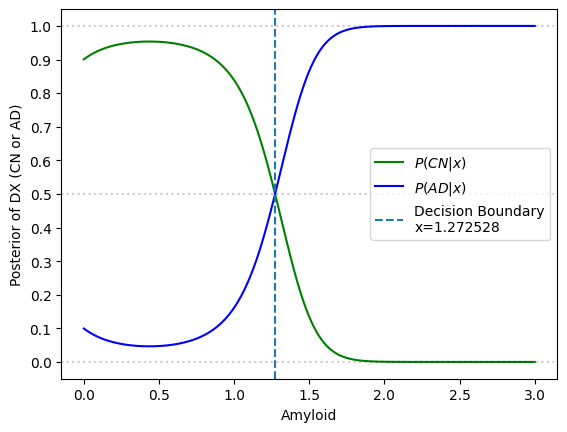

In [156]:
mu_CN2 = mu_CN * mu_CN
sig_CN2 = sig_CN * sig_CN
mu_AD2 = mu_AD * mu_AD
sig_AD2 = sig_AD * sig_AD

C = mu_AD2 * sig_CN2 - mu_CN2 * sig_AD2 - 2 * sig_AD2 * sig_CN2 * np.log(sig_CN / sig_AD)
A = sig_CN2 - sig_AD2
B = 2 * (mu_CN * sig_AD2 - mu_AD * sig_CN2)

x1 = (-B + np.sqrt(B * B - 4 * A * C)) / (2 * A)
x2 = (-B - np.sqrt(B * B - 4 * A * C)) / (2 * A)
xb = x1
if np.allclose(posterior_DX(x2, type='CN'), posterior_DX(x2, type='AD')):
    xb = x2

x = np.linspace(0, 3, num=1000)
yCN = posterior_DX(x, 'CN')
yAD = posterior_DX(x, 'AD')
plt.plot(x, yCN, c='g', label='$P(CN|x)$')
plt.plot(x, yAD, c='b', label='$P(AD|x)$')
plt.axvline(x2, 0, 1, linestyle='--', label='Decision Boundary\nx=%.6f'%x2)
plt.axhline(0.0, 0, 1, linestyle='dotted', c='black', alpha=0.2)
plt.axhline(0.5, 0, 1, linestyle='dotted', c='black', alpha=0.2)
plt.axhline(1.0, 0, 1, linestyle='dotted', c='black', alpha=0.2)
y_major_locator = plt.MultipleLocator(0.1)
ax = plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel('Amyloid')
plt.ylabel('Posterior of DX (CN or AD)')
plt.legend()

In [164]:
tot = 0
hit = 0
for idx, r in df_ad_cw1.iterrows():
    if r.DX == 'Dementia' or r.DX == 'CN':
        tot += 1
        if r.Amyloid < xb:
            if r.DX == 'CN':
                hit += 1
        else:
            if r.DX == 'Dementia':
                hit += 1
print(hit / tot)

0.799492385786802


**Conclusion: Decision Boundary is Amyloid=$1.272528$**

### b) Using sklearn LinearRegression

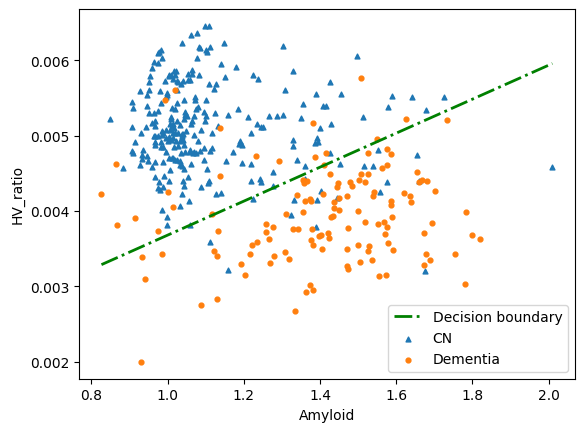

In [153]:
cats = ['CN', 'Dementia', 'MCI']
df_ad_cw1.DX = df_ad_cw1.DX.astype('category').cat.set_categories(cats)
df_ad_cw1["code"] = df_ad_cw1.DX.cat.codes
df_ad_cw1.DX = df_ad_cw1.DX.astype('str')

X = df_ad_cw1[df_ad_cw1.DX!='MCI'][['Amyloid', 'HV_ratio']].to_numpy()
Y = df_ad_cw1[df_ad_cw1.DX!='MCI']['code'].to_numpy()

reg = LinearRegression().fit(X, Y)
a0, a1 = reg.coef_
b = reg.intercept_

x0 = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), num=1000)
x1 = (0.5 - a0 * x0 - b) / a1

plt.scatter(X[Y==0][:, 0], X[Y==0][:, 1], marker='^', s=12, label='CN')
plt.scatter(X[Y==1][:, 0], X[Y==1][:, 1], s=12, label='Dementia')
plt.plot(x0, x1, c='g', linestyle='-.', linewidth=2, label='Decision boundary')
plt.xlabel('Amyloid')
plt.ylabel('HV_ratio')
plt.legend()


### c) Going  back  to  the  full dataset

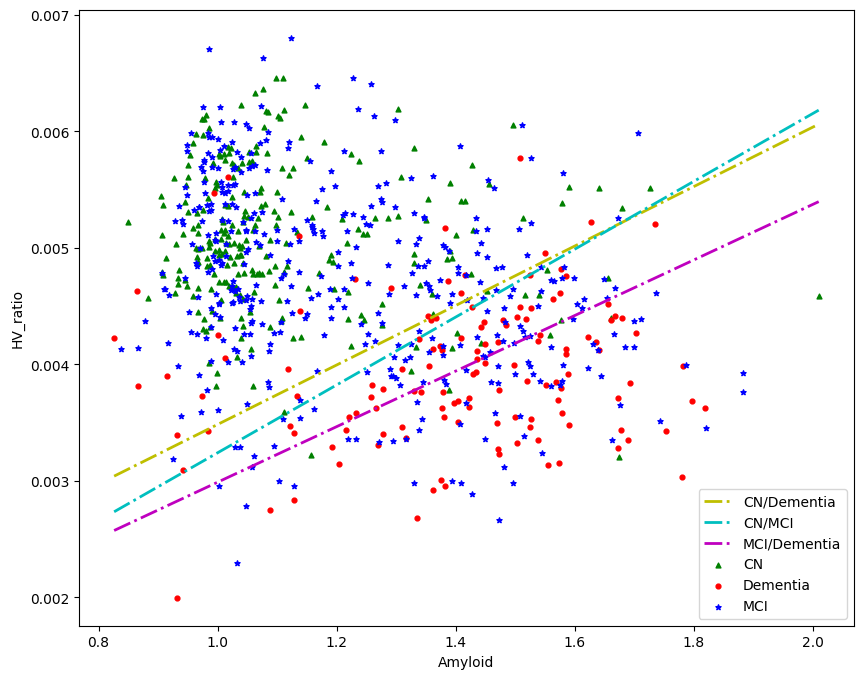

In [207]:
CN = df_ad_cw1[df_ad_cw1.DX=='CN'][['Amyloid', 'HV_ratio']].to_numpy()
AD = df_ad_cw1[df_ad_cw1.DX=='Dementia'][['Amyloid', 'HV_ratio']].to_numpy()
MCI = df_ad_cw1[df_ad_cw1.DX=='MCI'][['Amyloid', 'HV_ratio']].to_numpy()
mu_CN = np.mean(CN, axis=0)
mu_AD = np.mean(AD, axis=0)
mu_MCI = np.mean(MCI, axis=0)
SIG = ((CN - mu_CN).T @ (CN - mu_CN) + (AD - mu_AD).T @ (AD - mu_AD) + (MCI - mu_MCI).T @ (MCI - mu_MCI)) / (N - 3)
SIG_inv = np.linalg.inv(SIG)

mu_grp = {
    'CN': mu_CN,
    'AD': mu_AD,
    'MCI': mu_MCI
}

def get_decision_boundary(x0, grp0, grp1):
    
    mu_k = mu_grp[grp0]
    mu_l = mu_grp[grp1]

    b = -0.5 * ((mu_k - mu_l) @ SIG_inv @ (mu_k - mu_l).T)
    a0, a1 = SIG_inv @ (mu_k - mu_l)

    return (-a0 * x0 - b) / a1

cats = ['CN', 'Dementia', 'MCI']
df_ad_cw1.DX = df_ad_cw1.DX.astype('category').cat.set_categories(cats)
df_ad_cw1["code"] = df_ad_cw1.DX.cat.codes
df_ad_cw1.DX = df_ad_cw1.DX.astype('str')
X = df_ad_cw1[['Amyloid', 'HV_ratio']].to_numpy()
Y = df_ad_cw1['code'].to_numpy()
x0 = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), num=1000)

plt.figure(figsize=(10, 8))
plt.scatter(X[Y==0][:, 0], X[Y==0][:, 1], marker='^', s=12, label='CN', c='g')
plt.scatter(X[Y==1][:, 0], X[Y==1][:, 1], s=12, label='Dementia', c='r')
plt.scatter(X[Y==2][:, 0], X[Y==2][:, 1], marker='*', s=15, label='MCI', c='b')
plt.plot(x0, get_decision_boundary(x0, 'CN', 'AD'), c='y', linestyle='-.', linewidth=2, label='CN/Dementia')
plt.plot(x0, get_decision_boundary(x0, 'CN', 'MCI'), c='c', linestyle='-.', linewidth=2, label='CN/MCI')
plt.plot(x0, get_decision_boundary(x0, 'MCI', 'AD'), c='m', linestyle='-.', linewidth=2, label='MCI/Dementia')
plt.xlabel('Amyloid')
plt.ylabel('HV_ratio')
plt.legend()

## Exercise 2: Classifier Implementations

### a) Complete the code for Rosenblatt's Perceptron

In [ ]:
#implement rosenblatt's perceptron for a 2D example
#Y are the target labels (-1,1)
#X is the input data
#rho is the learning rate
#max_iter controls the maximum number of iterations
##Note: both, rho and max_iter can be left to their default values

#function returns the intercept_ (\beta_0) and the coefficients_ (\beta_i)
def rosen_perceptron(Y, X, rho=0.1, max_iter = 1000):
  #initialize with random parameters
  intercept_ = np.random.randn()
  #as many coefficients as there are columns (features) in X
  coef_ = np.random.randn(X.shape[1])
  
  #make predictions
  Y_hat = intercept_ + np.dot(X, coef_)  
  
  #compute the list of misclassified samples and store in M  
  M = 

  iter = 0
  #as long as there are misclassified samples in M and we have not reached the
  #maximal number of interations continue to update coefficients etc.
  while len(M) > 0 and iter < max_iter:

    #make gradient step (update intercept and coefficients)
    intercept_  =
    coef_       = 

    #make predictions using new parameters
    Y_hat = intercept_ + np.dot(X, coef_)

    ##update the list of misclassified samples and store in M  
    M = 

    iter += 1
  
  return intercept_, coef_

### b) Complete the code for LogisticRegression via Gradient Descent

In [4]:
#define the sigmoid function
def sigmoid(value):
    return expit(value)

In [ ]:
#this function fits Logistic Regression using Gradient Descent
#inputs are
#y:         target labels (0,1)
#features:  input feature matrix
#eps:       tolerance for the stopping criterion
#rho:       step size in gradient descent

#this function returns the beta coefficients for a LogisticRegression model
#the first entry (betas[0] is the intercept)
def fit_LogReg_GRAD(y, features, eps=0.00000000001, rho=0.01):
    #sample size
    N = features.shape[0]
    #feature dim
    p = features.shape[1] + 1
    #initalize beta with 0s
    betas = np.zeros(p)

    #add column of 1 to X
    X = np.c_[np.ones(N),features]
    #compute predictions for class 1
    prob1 = sigmoid( X @ betas)
    #compute predictions for class 2
    prob0 = 1.0 - prob1

    old_cost = 100000000
    #compute the cost (J) of the current solution
    #COMPLETE THIS LINE
    cost = 
    #as long as the there is a differentce between old and new cost that is larger
    #than the tolerance we update the parameters
    while np.abs(old_cost - cost) > eps:
        #beta update (one step of the gradient descent)
        #COMPLETE THIS LINE
        betas =

        #update probabilities
        prob1 = sigmoid( X @ betas)
        prob0 = 1.0 - prob1
        
        #deal with 'underflow'
        prob1[prob1 == 0] = 0.000001
        prob0[prob0 == 0] = 0.000001

        old_cost = cost
        #recompute cost
        #COMPLETE THIS LINE
        cost = 

        #reduce learning rate in case the cost increased
        if cost > old_cost:
          rho /= 2
    
    return(betas)

### c) Complete the code for HingeLoss with L2 regularization using Gradient Descent

In [ ]:
#this function fits a linear classifier with Hinge Loss and L2 regularization using Gradient Descent
#inputs are
#y:         target labels (0,1)
#features:  input feature matrix
#lam:       the regularization parameter \lambda
#eps:       tolerance for the stopping criterion
#rho:     step size in gradient descent
#max_iter:  maximum number of iterations the algorithm is run

#this function returns the beta coefficients for a HingeL2 linear model
#the first entry (betas[0] is the intercept)

def fit_HingeL2_GRAD(y, features, lam=1, eps=0.00000000001, rho=0.01, max_iter=1000):
    #sample size
    N = features.shape[0]
    #feature dim
    p = features.shape[1] + 1
    #initalize beta random values  
    betas = np.random.normal(size=p)

    #add column of 1 to X
    X = np.c_[np.ones(N),features]
    #prediction, using a linear model
    yhat = X @ betas
  
    #initialize old_cost with a very high value
    old_cost = 100000000
    #compute the cost (J) of the current solution
    #COMPLETE THIS 
    cost = 
      
    epoch=0
    while epoch < max_iter and np.abs(old_cost - cost) > eps:
        epoch += 1
        #beta update (one step of the gradient descent)
        #COMPLETE THIS 
        betas =

        #update prediction
        yhat = X @ betas    
        
        old_cost = cost
        #recompute cost
        #COMPLETE THIS (same as above)        
        cost = 

        #reduce learning rate in case the cost increased
        if cost > old_cost:
          rho /= 2
    return(betas)

## Exercise 3: Suggest improvements to the ML pipeline



1.   
2.  
3. 
4. 



## Exercise 4: Vessel Segmentation

In [7]:
import imageio
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn import svm
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import image
from skimage.filters import scharr
from skimage.color import rgb2gray


In [5]:
train_path = ''
vali_path = ''
test_path = ''

In [ ]:
#this function takes an input image and
#does the manual feature extraction
#color image? grayscale? just one channel? apply any filters?
#if the variable nchan is sset to True, then the return is just the number of channels

def preprocess_img(img, nchan=False):
    #some examples for pre-processing:

    ##E.g., do nothing
    ##copy all three channels
    #res = img

    ##use just the green channel
    #res = img[:,:,1]  

    ##single channel gray    
    res = rgb2gray(img) * 255

    #add some edge filter applied to the gray-scale image
    res = np.dstack((res, scharr(rgb2gray(img)) * 255))
    
    #if nchan is True, then just return the number of channels
    #the pre-processing produces
    if nchan:
        try:
            return(res.shape[2])
        except IndexError:
            return(1)
    return (res)

In [8]:
#turn the images into a training dataset

#train_path:    path to the training data
#n_train_patch: number of patches to be extracted per image
#ps :           patch size as integer (e.g., 9 -> 9x9 patches)
#chan:          number of 'channels' the pre_processed image will have
#verbose:       if True, print some updates on the processing

def create_training_set(train_path, n_train_patch, ps, chan, verbose=True):
  if verbose:
    print("Extracting " + str(n_train_patch) + " pataches of size " + str(ps) + "x" + str(ps) + " from each image.")

  #dimension of square patch
  patch_dim = (ps, ps)
  #center of the patch
  patch_cnt = int((ps-1)/2)
  #dimension of the 'flattened' patch  (i.e., a single vector)  
  flat_dim = ps*ps*chan

  #initialize Y and X
  Y = []
  X = np.empty((0,flat_dim))

  for s in np.arange(80):
    if verbose:
      print("Extracting data from subject: " + str(s))
    tmp =     train_path + 'images/' + str(s) + '.png'
    tmp_msk = train_path + 'masks/' + str(s) + '.png'
    
    img_m = imageio.imread(tmp)
    msk_x = imageio.imread(tmp_msk)
    #binarize the mask
    msk = (msk_x > 0) * 1

    #extract features (using the function defined above)
    frames = preprocess_img(img_m)

    #add the labels as an additional channel
    frames = np.dstack((frames, msk))

    #sample patches    
    patch = image.extract_patches_2d(frames, patch_dim, max_patches=n_train_patch)
    
    #each patch receives the label of the center value in the 'label' channel
    Y_tmp = patch[:,patch_cnt,patch_cnt,chan] == 1

    #turn patches into a matrix where each row corresponds to all the features
    #of one patch
    X_tmp = np.reshape(patch[:,:,:,0:chan],(n_train_patch,flat_dim))
    
    #concatenate with Y and X
    Y.extend(Y_tmp)
    X = np.concatenate((X, X_tmp), axis=0)
  return (Y, X)

In [ ]:
#that is a bit clunky to get the channel size
im = imageio.imread(train_path + 'images/0.png')
chan = preprocess_img(im, True)

In [ ]:
#show the input image
plt.imshow(im)

### code for parts a) - f)